In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import json
import logging
import os
from datetime import datetime
from pathlib import Path
from typing import Any

import joblib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import tomllib
from dotenv import load_dotenv

from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import (
    expand_feature_list,
    load_data_from_database,
    prepare_data,
)
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.make_model_plots import InferenceCache, load_model_and_data
from src.plots.model_inference import (
    analyze_test_dataset_for_one_stimulus,
    plot_prediction_confidence_heatmap,
)
from src.plots.model_performance import (
    create_performance_table,
    get_confusion_matrix,
    get_model_predictions,
    plot_multiple_pr_curves,
    plot_multiple_roc_curves,
    plot_single_roc_curve,
)
from src.plots.model_performance_per_participant import (
    aggregate_accuracy_stats,
    analyze_per_participant,
    plot_feature_accuracy_boxplot,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "filelock"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials

polars.config.Config

In [3]:
feature_lists = [
    # ["eda_raw"],
    # ["heart_rate"],
    # ["pupil"],
    # ["eda_raw", "pupil"],
    # ["eda_raw", "heart_rate"],
    ["eda_raw", "heart_rate", "pupil"],
    # ["face"],
    # ["face", "eda_raw", "heart_rate", "pupil"],
    # ["eeg"],
    # ["eeg", "eda_raw"],
    # ["eeg", "face", "eda_raw", "heart_rate", "pupil"],
]
feature_lists = expand_feature_list(feature_lists)
feature_list = feature_lists[0]
feature_list_str = "_".join(feature_list)

In [4]:
results = {}
winning_models = {}

cache = InferenceCache()

for feature_list in feature_lists:
    feature_list_str = "_".join(feature_list)

    # Check cache validity
    json_path = Path(f"results/experiment_{feature_list_str}/results.json")
    dictionary = json.loads(json_path.read_text())
    model_path = Path(dictionary["overall_best"]["model_path"].replace("\\", "/"))

    # Try to get cached predictions
    if cache._is_cache_valid(feature_list_str, model_path):
        cached_predictions = cache.get(feature_list_str, "test_predictions")
        if cached_predictions:
            logging.info(f"Using cached predictions for {feature_list_str}")
            results[feature_list_str] = (
                cached_predictions["probs"],
                cached_predictions["y_true"],
            )
            winning_models[feature_list_str] = {
                feature_list_str: cached_predictions["model_name"]
            }
            continue

    # Load and predict if not cached
    model, model_config, _, test_loader, _ = load_model_and_data(
        feature_list, feature_list_str
    )

    winning_models[feature_list_str] = {feature_list_str: model_config["model_name"]}

    probs, y_true = get_model_predictions(model, test_loader)
    results[feature_list_str] = (probs, y_true)

    # Cache the predictions
    cache._update_timestamp(feature_list_str, model_path)
    cache.set(
        feature_list_str,
        "test_predictions",
        {
            "probs": probs,
            "y_true": y_true,
            "model_name": model_config["model_name"],
        },
    )

13:19:26 | DEBUG   | root | Cache hit: eda_raw_heart_rate_pupil_test_predictions
13:19:26 | INFO    | root | Using cached predictions for eda_raw_heart_rate_pupil


In [5]:
results = {}
winning_models = {}

for feature_list in feature_lists:
    feature_list_str = "_".join(feature_list)
    # Load data from database
    df = load_data_from_database(feature_list=feature_list)

    # Load model
    json_path = Path(f"results/experiment_{feature_list_str}/results.json")
    dictionary = json.loads(json_path.read_text())
    model_path = Path(dictionary["overall_best"]["model_path"].replace("\\", "/"))

    model, feature_list, sample_duration_ms, intervals, label_mapping, offsets_ms = (
        load_model(model_path, device="cpu")
    )
    winning_models[feature_list_str] = {feature_list_str: model.__class__.__name__}

    # Prepare data
    X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test = (
        prepare_data(
            df=df,
            feature_list=feature_list,
            sample_duration_ms=sample_duration_ms,
            intervals=intervals,
            label_mapping=label_mapping,
            offsets_ms=offsets_ms,
            random_seed=RANDOM_SEED,
        )
    )
    test_groups = prepare_data(
        df=df,
        feature_list=feature_list,
        sample_duration_ms=sample_duration_ms,
        intervals=intervals,
        label_mapping=label_mapping,
        offsets_ms=offsets_ms,
        random_seed=RANDOM_SEED,
        only_return_test_groups=True,
    )
    _, test_loader = create_dataloaders(
        X_train_val, y_train_val, X_test, y_test, batch_size=64
    )
    probs, y_true = get_model_predictions(
        model,
        test_loader,
    )
    results[feature_list_str] = (probs, y_true)

13:19:26 | INFO    | utils | Using device: cpu
13:19:26 | INFO    | utils | Loaded PatchTST model with test accuracy 0.77 to cpu
13:19:26 | INFO    | utils | Input shape: (70, 3) | Features: ['eda_raw', 'heart_rate', 'pupil'] | Sample duration: 7000 ms
13:19:26 | DEBUG   | utils | Intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
13:19:26 | DEBUG   | utils | Label mapping: {'increases': 0, 'plateaus': 0, 'decreases': 1}
13:19:26 | DEBUG   | utils | Offset ms: {'increases': 0, 'plateaus': 5000, 'decreases': 1000}
13:19:26 | DEBUG   | sample_creation | Removed 749 samples with less than 69 data points
13:19:27 | DEBUG   | data_preparation | Preparing data with sample duration 7000 ms and random seed 42
13:19:27 | DEBUG   | data_preparation | Samples are based on intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
13:19:27 | 

In [6]:
predictions, true_labels = results[feature_list_str]

In [7]:
probs = results[feature_list_str][0]
y_true = results[feature_list_str][1]

/Users/visser/drive/PhD/Code/pain-measurement/src/plots/model_performance.py:88: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  conf_matrix_plot.show()


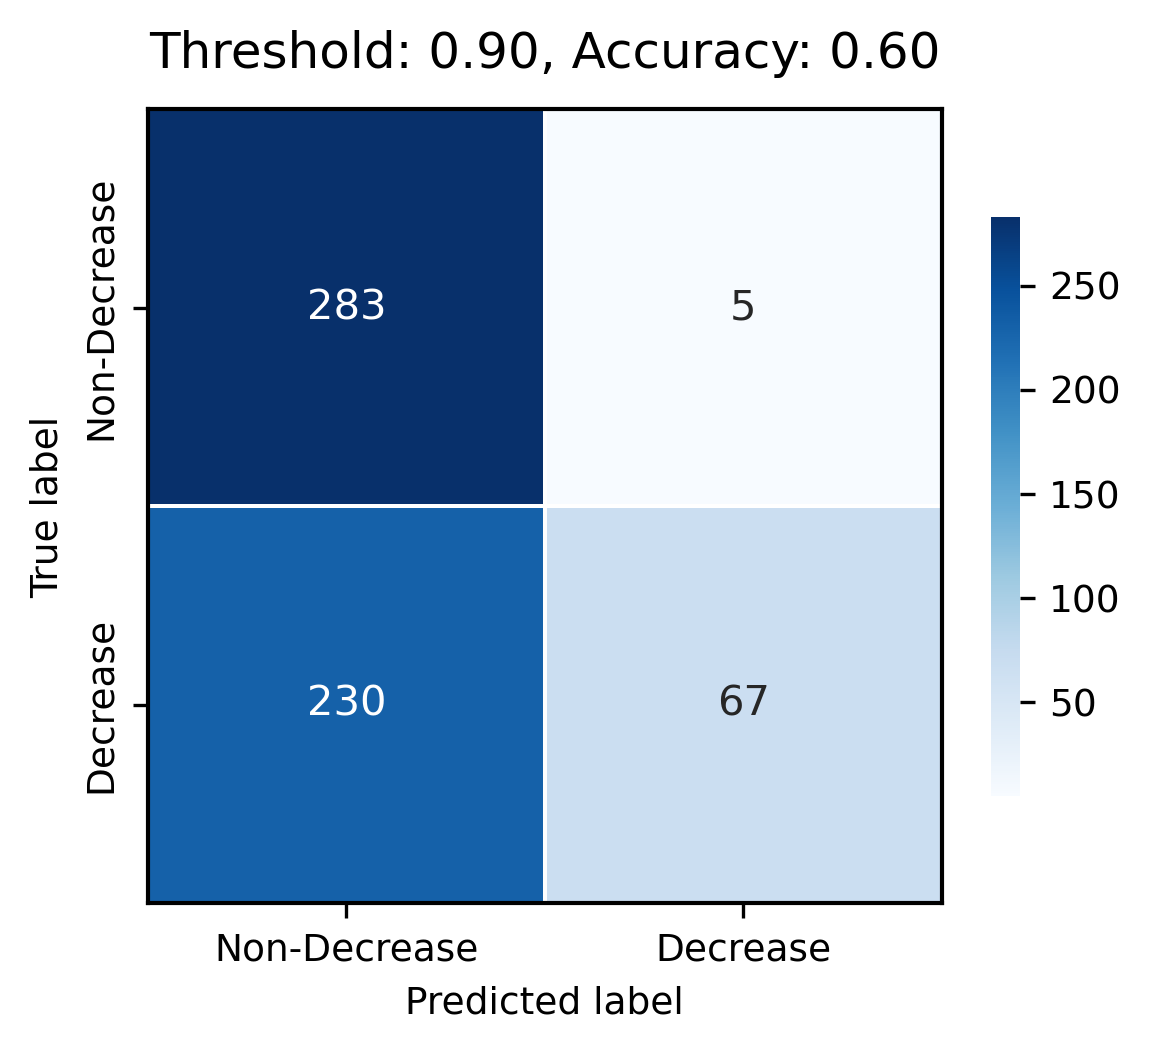

In [8]:
conf_matrix_05 = get_confusion_matrix(probs, y_true, threshold=0.9)
